# Constants

In [ ]:
dataset_path = '/content/drive/My Drive/Challenge_3/anndl-2020-vqa.zip'
images_path = '/content/VQA_Dataset/Images/'
train_json_path = '/content/VQA_Dataset/train_questions_annotations.json'
test_json_path = '/content/VQA_Dataset/test_questions.json'
    
SEED = 1234

VALIDATION_SPLIT = 0.10

IMG_H = 400
IMG_W = 700

BATCH_SIZE = 25

classes = {
            '0': 0,
            '1': 1,
            '2': 2,
            '3': 3,
            '4': 4,
            '5': 5,
            'apple': 6,
            'baseball': 7,
            'bench': 8,
            'bike': 9,
            'bird': 10,
            'black': 11,
            'blanket': 12,
            'blue': 13,
            'bone': 14,
            'book': 15,
            'boy': 16,
            'brown': 17,
            'cat': 18,
            'chair': 19,
            'couch': 20,
            'dog': 21,
            'floor': 22,
            'food': 23,
            'football': 24,
            'girl': 25,
            'grass': 26,
            'gray': 27,
            'green': 28,
            'left': 29,
            'log': 30,
            'man': 31,
            'monkey bars': 32,
            'no': 33,
            'nothing': 34,
            'orange': 35,
            'pie': 36,
            'plant': 37,
            'playing': 38,
            'red': 39,
            'right': 40,
            'rug': 41,
            'sandbox': 42,
            'sitting': 43,
            'sleeping': 44,
            'soccer': 45,
            'squirrel': 46,
            'standing': 47,
            'stool': 48,
            'sunny': 49,
            'table': 50,
            'tree': 51,
            'watermelon': 52,
            'white': 53,
            'wine': 54,
            'woman': 55,
            'yellow': 56,
            'yes': 57
}

N_CLASSES = len(classes)



# Initial Setup



In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
from datetime import datetime
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image
import json
import math
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cv2
import glob

import tensorflow_datasets as tfds

from imageio import imread

In [ ]:
# Set the seed for random operations. 
# Letting experiments to be reproducible. 
tf.random.set_seed(SEED) 
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# RetriEval

In [ ]:
! unzip '$dataset_path'

# Tokenizer

In [ ]:
#----------------------------------
#Filters to deal with Word Bias
#----------------------------------

def preprocess_question(question):

  # "'" token is removed to deal with saxon genitives or similar
  question = question.replace("'", " ")

  question = question.replace('?', '')

  #remove grammar mistakes
  question = question.replace("crossedq", "crossed")   
  question = question.replace("doorwh", "door")

  return question

black_list = [
              "to",
              "of",
              "s",
               "they",
              "with",
              "it",
               "she",
               "at",
               "for",
               "you",
                "he",
                 "will",
                 "can",
                 "about",
                "from",
                "by",
              "as",
              "and",

# the majority of the "s" tokens comes from the truncated "'s" (saxon genitive) after applying the previous filter

]

#Just filter the questions eliminating words in the blacklist
def remove_tokens(question):
  question_filtered = []
  for word in question:
    if word not in black_list:
      question_filtered.append(word)
  
  return question_filtered

In [ ]:
def read_train_json():

  with open(train_json_path, 'r') as f:
    data = json.load(f)
  f.close()

  images = []
  questions = []
  answers = []

  for index in data:

    img_id = data[index]['image_id']

    question = data[index]['question']
    question = preprocess_question(question).split(" ")
    question = remove_tokens(question)


    for word in question:
       if word in black_list:
         print("Error, found ",  word)
         
    answer = data[index]['answer']

    images.append(img_id + '.png')
    questions.append(question)
    answers.append(classes[answer])

  TRAIN_SPLIT = math.ceil(len(images) * (1 - VALIDATION_SPLIT))
  train_images = images[:TRAIN_SPLIT]
  valid_images = images[TRAIN_SPLIT:]

  train_questions = questions[:TRAIN_SPLIT]
  valid_questions = questions[TRAIN_SPLIT:]

  train_answers = answers[:TRAIN_SPLIT]
  valid_answers = answers[TRAIN_SPLIT:]

  return train_images, train_questions, train_answers, valid_images, valid_questions, valid_answers

def read_test_json():

  with open(test_json_path, 'r') as f:
    data = json.load(f)
  f.close()

  ids = []
  images = []
  questions = []

  for index in data:
    
    img_id = data[index]['image_id']

    question = data[index]['question'].split(' ')
    question[-1] = question[-1].replace('?', '')
    
    ids.append(index)
    images.append(img_id + '.png')
    questions.append(question)

  return images, questions, ids

In [ ]:
#extract images, questions and answer (or quest_id) from the train and test files
train_images, train_questions, train_answers, valid_images, valid_questions, valid_answers = read_train_json()

In [ ]:
# Use the Tokenizer to transform the text (questions) into sequence
tokenizer = tf.keras.preprocessing.text.Tokenizer()

with open(train_json_path, 'r') as f:

  data = json.load(f)

  for index in data:
    question = data[index]['question']
    question = preprocess_question(question)
    question = question.split(' ')
    question = remove_tokens(question)
    # Updates internal vocabulary based on the questions of the dataset
    tokenizer.fit_on_texts(question)

f.close()

words_number = len(tokenizer.word_index) + 1 # + 1 is there to count the padding (element number 0)

In [ ]:
len(tokenizer.word_index)

4515

In [ ]:
with open(train_json_path, 'r') as f:
  data = json.load(f)
int(len(data) * (1 - VALIDATION_SPLIT))

52948

In [ ]:
sequences = tokenizer.texts_to_sequences(train_questions)
max_length_train = max(len(sequence) for sequence in sequences)

sequences = tokenizer.texts_to_sequences(valid_questions)
max_length_valid = max(len(sequence) for sequence in sequences)

if max_length_valid > max_length_train:
  max_length = max_length_valid
else:
  max_length = max_length_train

train_input_questions = pad_sequences(sequences, maxlen=max_length)
valid_input_questions = pad_sequences(sequences, maxlen=max_length)

# Dataset Setup

In [ ]:
# -------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects
# -------------------------------------------------------------
def data_generator(apply_data_augmentation = True):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  apply_data_augmentation = True

  # Create training ImageDataGenerator object
  # We need two different generators for images and corresponding masks
  if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    
  return img_data_gen

In [ ]:
# --------------------------------
# Create the class for the dataset
# --------------------------------

from PIL import Image

class TrainDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, tokenizer, set_type, img_generator=None, preprocessing_function=None, img_shape=[400, 700]):
    import json
    
    with open(train_json_path, 'r') as f:
      data = json.load(f)
    
    # Tokenizer fuori perche deve creare variabili globali come word_number ecc.

    self.data = {}
    for i, j in enumerate(data):

      if set_type == 'training':

        if i + 1 <= int(len(data) * (1 - VALIDATION_SPLIT)):
          self.data[i] = data[j]
        else:
          break
      
      else:
        
        if i + 1 > int(len(data) * (1 - VALIDATION_SPLIT)):
          self.data[i-int(len(data) * (1 - VALIDATION_SPLIT))] = data[j] # self.data[i-int(len(data) * (1 - VALIDATION_SPLIT))] to obtain from index 0
        else:
          continue
        

    self.tokenizer = tokenizer
    
    self.img_generator = img_generator
    
    self.preprocessing_function = preprocessing_function
    
    self.img_shape = img_shape

    self.SEED = 1234

  def __len__(self):
    return len(self.data)
  
  def on_epoch_end(self):

    new_indexes = range(len(self.data))
    np.random.shuffle(new_indexes)
    
    new_data = {}
    for i, j in enumerate(new_indexes):
      new_data[i] = self.data[j]
    
    self.data = new_data

  def __getitem__(self, index):

    curr_element = self.data[index]

    # -----
    # Image
    # -----
    
    # Read Image
    img = cv2.imread(images_path + curr_element['image_id'] + '.png', cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB ) 
    # Resize image
    img = cv2.resize(img, (self.img_shape[1], self.img_shape[0]), interpolation = cv2.INTER_AREA) #size – The requested size in pixels, as a 2-tuple: (WIDTH, HEIGHT). ! ATTENTION ! cv2 function
    
    if self.img_generator is not None:
      # Perform data augmentation
      # We can get a random transformation from the ImageDataGenerator using get_random_transform
      # and we can apply it to the image using apply_transform

      #self.SEED = self.SEED + 1
      img_t = self.img_generator.get_random_transform(img.shape, seed=self.SEED)
      img = self.img_generator.apply_transform(img, img_t)
    
    if self.preprocessing_function is not None:
      img = self.preprocessing_function(img)

    # --------
    # Question
    # --------

    question = [curr_element['question']]
    question = preprocess_question(question[0])  # eliminate grammar mistakes and saxon genitives
    question = question.split(" ")
    question = remove_tokens(question)  #remove tokens in the blacklist to deal with word bias
    whitespace = " "
    question = [whitespace.join(question)]

    question = self.tokenizer.texts_to_sequences(question)
    question = pad_sequences(question, padding = 'post', maxlen = max_length)
    question = question[0]
    
    # --------
    # Answer
    # ------

    answer = curr_element['answer']

    answer = classes[answer]
    indices = range(N_CLASSES)
    depth = N_CLASSES
    answer = tf.one_hot(indices, depth)[answer].numpy()

    return (np.float32(img), np.int32(question)), np.int32(answer)

In [ ]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_dataset(img_data_gen, img_h, img_w, bs, num_classes):

  # Training
  # --------
  train_gen = TrainDataset(tokenizer = tokenizer,
                           set_type = 'training',
                           #img_generator = data_generator(), 
                           img_shape = [img_h, img_w], # size – The requested size in pixels, as a 2-tuple: (h, w). !! np function
                           preprocessing_function = None
                          )
  
  train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                                 output_types = ((tf.float32, tf.int32), tf.int32),
                                                 output_shapes = (([img_h, img_w, 3], [max_length]), N_CLASSES))
                                                                                            
  train_dataset = train_dataset.batch(bs)

  train_dataset = train_dataset.repeat()
  # --------

  # Training
  # --------
  valid_gen = TrainDataset(tokenizer = tokenizer,
                           set_type = 'validation',
                           img_generator = None, 
                           img_shape = [img_h, img_w], # size – The requested size in pixels, as a 2-tuple: (h, w). !! np function
                           preprocessing_function = None
                          )
  
  valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                                 output_types = ((tf.float32, tf.int32), tf.int32),
                                                 output_shapes = (([img_h, img_w, 3], [max_length]), N_CLASSES))
                                                                                            
  valid_dataset = valid_dataset.batch(bs)

  # --------

  print('Training samples: ' + str(len(train_gen)))
  print('Validation samples: ' + str(len(valid_gen)))

  return train_dataset, train_gen, valid_dataset, valid_gen

In [ ]:
train_dataset, train_gen, valid_dataset, valid_gen = create_dataset(img_data_gen = None, img_h = IMG_H, img_w= IMG_W, bs = BATCH_SIZE, num_classes= N_CLASSES)

train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

Training samples: 52948
Validation samples: 5884


(25, 400, 700, 3)


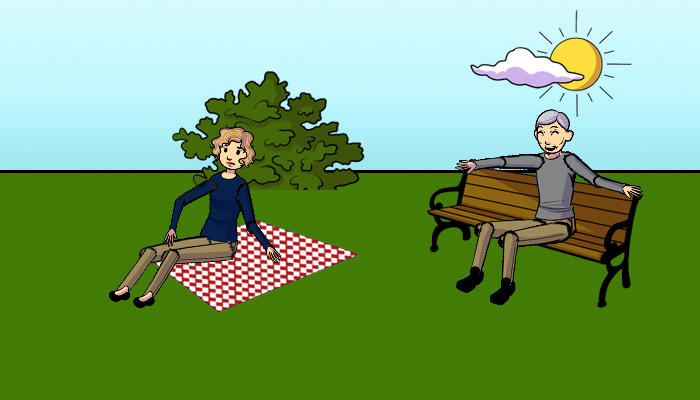

<tf.Tensor: shape=(19,), dtype=int32, numpy=
array([  38,  772, 1856,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)>

<tf.Tensor: shape=(58,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
from google.colab.patches import cv2_imshow

for (image, question), answer in train_dataset:
  print(image.shape)
  cv2_imshow(np.array(image[0]))
  question[0]
  answer[0]    
  break

#Embedding


In [ ]:
#--------------------------------------------------------------------------------------------------------------------
# Load pre-trained embedding, build the embedding matrix (evaluating the number of missing tokens during the building)
#--------------------------------------------------------------------------------------------------------------------

! wget http://nlp.stanford.edu/data/glove.42B.300d.zip
! unzip -q glove.42B.300d.zip

path_to_glove_file = os.path.join("/content/glove.42B.300d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

# ------------------------------------------------------------

embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((words_number, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:  
        print(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

--2021-01-29 19:15:46--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2021-01-29 19:15:46--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-01-29 19:15:47--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [ ]:
tokenizer.word_index

{'the': 1,
 'is': 2,
 'are': 3,
 'what': 4,
 'how': 5,
 'many': 6,
 'on': 7,
 'in': 8,
 'color': 9,
 'there': 10,
 'a': 11,
 'man': 12,
 'woman': 13,
 'dog': 14,
 'girl': 15,
 'boy': 16,
 'does': 17,
 'sitting': 18,
 'this': 19,
 'people': 20,
 'cat': 21,
 'where': 22,
 'have': 23,
 'picture': 24,
 'table': 25,
 'playing': 26,
 'do': 27,
 'couch': 28,
 'lady': 29,
 'doing': 30,
 'baby': 31,
 'room': 32,
 'tree': 33,
 'rug': 34,
 'her': 35,
 'ball': 36,
 'same': 37,
 'who': 38,
 'holding': 39,
 'trees': 40,
 'see': 41,
 'old': 42,
 'shirt': 43,
 'any': 44,
 'little': 45,
 'pond': 46,
 'windows': 47,
 'will': 48,
 'sun': 49,
 'animal': 50,
 'fire': 51,
 'animals': 52,
 'that': 53,
 'chair': 54,
 'tv': 55,
 'be': 56,
 'going': 57,
 'happy': 58,
 'his': 59,
 'slide': 60,
 'wall': 61,
 'curtains': 62,
 'clouds': 63,
 'sky': 64,
 'two': 65,
 'did': 66,
 'having': 67,
 'fireplace': 68,
 'bench': 69,
 'floor': 70,
 'birds': 71,
 'sleeping': 72,
 'food': 73,
 'chairs': 74,
 'standing': 75,
 'so

#Model Setup


In [ ]:
#-----------------
# Attention model
#-----------------

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  
        key = self.key_dense(inputs)  
        value = self.value_dense(inputs)  
        query = self.separate_heads(
            query, batch_size
        )  
        key = self.separate_heads(
            key, batch_size
        )  
        value = self.separate_heads(
            value, batch_size
        )  
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  
        output = self.combine_heads(
            concat_attention
        )  
        return output

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length = maxlen, 
                                                   embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), mask_zero=True, trainable = False)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#----------------------------------------------------------------------------
# Model with embeddings learned from the data (not used in our final version) 
#----------------------------------------------------------------------------

def define_model_old():      #not used anymore

    CNN_Input = tf.keras.layers.Input(shape=(IMG_H,IMG_W,3), name='image_input')

    efficient = tf.keras.applications.EfficientNetB7(input_shape=(IMG_H, IMG_W,3), include_top=False, weights='imagenet', input_tensor=CNN_Input)

    efficient.trainable = True
    for layer in efficient.layers:
      layer.trainable = False
      
      if ("block7" in layer.name):
        layer.trainable = True
      if "_bn" in layer.name:
        layer.trainable = False
      if 'top_conv' == layer.name:
        layer.trainable = True
      if 'top_activation' == layer.name:
        layer.trainable = True

    CNN_model=tf.keras.models.Sequential()
    CNN_model.add(CNN_Input)
    CNN_model.add(efficient)
    CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())

    #Creating the RNN model for text processing
    RNN_model = tf.keras.models.Sequential()

    RNN_Input = tf.keras.layers.Input(shape = (max_length), name='text_input')
    RNN_model.add(RNN_Input)

    '''
    #RNN_model.add(tf.keras.layers.Embedding(input_dim = words_number, output_dim = 2048, input_length = max_length, mask_zero=True))

    # GloVe 100 dimensional embeddings
    RNN_model.add(tf.keras.layers.Embedding(input_dim = words_number, output_dim = embedding_dim, input_length = max_length, 
                                            embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), mask_zero=True, trainable = False))

    RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
    RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=False, recurrent_initializer='glorot_uniform')))
    #RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
    #RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=False, recurrent_initializer='glorot_uniform')))
    '''

    embed_dim = 1024  # Embedding size for each token
    num_heads = 8  # Number of attention heads
    ff_dim = 64  # Hidden layer size in feed forward network inside transformer

    RNN_model.add(TokenAndPositionEmbedding(max_length, words_number, embed_dim))
    RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    RNN_model.add(tf.keras.layers.GlobalAveragePooling1D())

    concat = tf.keras.layers.concatenate([CNN_model.output, RNN_model.output])

    dense_out = tf.keras.layers.Dense(512, activation='relu', activity_regularizer = tf.keras.regularizers.l2(1e-5))(concat)
    tf.keras.layers.Dropout(0.2, seed=SEED)

    dense_out = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output')(dense_out)

    CNN_model.trainable = False

    model = tf.keras.Model(inputs=[CNN_Input, RNN_Input],
                          outputs = dense_out)

    return model

In [ ]:
def define_model():

    CNN_Input = tf.keras.layers.Input(shape=(IMG_H,IMG_W,3), name='image_input')

    #mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_H,IMG_W,3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=CNN_Input)

    efficient = tf.keras.applications.EfficientNetB7(input_shape=(IMG_H,IMG_W,3), include_top=False, weights='imagenet', input_tensor=CNN_Input)

    efficient.trainable = False

    for layer in efficient.layers:
      
      layer.trainable = False
    '''
      #if ("block4" in layer.name):
      #  layer.trainable = True
      #if ("block5" in layer.name):
      # layer.trainable = True
      #if ("block6" in layer.name):
      #  layer.trainable = True
      if ("block7" in layer.name):
      layer.trainable = True
      if "_bn" in layer.name:
      layer.trainable = False
      if 'top_conv' == layer.name:
      layer.trainable = True
      if 'top_activation' == layer.name:
      layer.trainable = True
    '''
    # Print the layer of the EfficientNet-B7 and if they are set to trainable
    #print(str(layer.name) + ' '*(35 - len(str(layer.name))) + '----> Trainable: ' + str(layer.trainable))

    #efficient.summary()

    CNN_model=tf.keras.models.Sequential()
    CNN_model.add(CNN_Input)
    CNN_model.add(efficient)
    CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())
    CNN_model.add(tf.keras.layers.Dense(512, activation='relu', 
                                    #kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                    #bias_regularizer = tf.keras.regularizers.l2(1e-4),
                                    activity_regularizer = tf.keras.regularizers.l2(1e-5)))
    CNN_model.add(tf.keras.layers.Dropout(0.2, seed=SEED))


    #shape = tf.shape(CNN_model.output)
    #OUT = tf.reshape(CNN_model.output, (-1, 286, shape[3]))

    #OUT = tf.reduce_mean(CNN_model.output, 1)

    #OUT = TransformerBlock(2560, 8, 64)(OUT)
    #OUT = tf.keras.layers.GlobalAveragePooling1D()(OUT)

    #Creating the RNN model for text processing

    RNN_model = tf.keras.models.Sequential()
    RNN_Input = tf.keras.layers.Input(shape = (max_length), name='text_input')
    RNN_model.add(RNN_Input)

    '''
    #RNN_model.add(tf.keras.layers.Embedding(input_dim = words_number, output_dim = 2048, input_length = max_length, mask_zero=True))

    # GloVe 100 dimensional embeddings
    RNN_model.add(tf.keras.layers.Embedding(input_dim = words_number, output_dim = embedding_dim, input_length = max_length, 
                                          embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), mask_zero=True, trainable = False))

    RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
    RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=False, recurrent_initializer='glorot_uniform')))
    #RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
    #RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=False, recurrent_initializer='glorot_uniform')))
    '''

    embed_dim = 300  # Embedding size for each token
    num_heads = 6  # Number of attention heads
    ff_dim = 16  # Hidden layer size in feed forward network inside transformer

    RNN_model.add(TokenAndPositionEmbedding(max_length, words_number, embed_dim))
    '''
    OUT = tf.keras.layers.Dense(1024, activation='relu')(CNN_model.output)

    OUT = tf.keras.layers.Multiply()([tf.expand_dims(OUT, axis = 1), TOKEN_model.output])

    OUT = TransformerBlock(embed_dim, num_heads, ff_dim)(OUT)

    OUT = tf.keras.layers.GlobalAveragePooling1D()(OUT)
    '''

    RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    #RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    RNN_model.add(tf.keras.layers.GlobalAveragePooling1D())


    concat = tf.keras.layers.concatenate([CNN_model.output, RNN_model.output])


    dense_out = tf.keras.layers.Dense(256, activation='relu', 
                                    #kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                    #bias_regularizer = tf.keras.regularizers.l2(1e-4),
                                    activity_regularizer = tf.keras.regularizers.l2(1e-5))(concat)
    #dense_out = tf.keras.layers.Dense(128, activation='relu')(dense_out)
    tf.keras.layers.Dropout(0.2, seed=SEED)

    dense_out = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output')(dense_out)

    model = tf.keras.Model(inputs=[CNN_Input, RNN_Input],
                          outputs = dense_out)

    return model


In [ ]:
def define_fine_tuning():

    CNN_Input = tf.keras.layers.Input(shape=(IMG_H,IMG_W,3), name='image_input')

    #mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_H,IMG_W,3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=CNN_Input)

    efficient = tf.keras.applications.EfficientNetB7(input_shape=(IMG_H,IMG_W,3), include_top=False, weights='imagenet', input_tensor=CNN_Input)

    efficient.trainable = True

    for layer in efficient.layers:
      layer.trainable = False

      #if ("block4" in layer.name):
      #  layer.trainable = True
      #if ("block5" in layer.name):
        # layer.trainable = True
      #if ("block6" in layer.name):
      #  layer.trainable = True
      if ("block7" in layer.name):
        layer.trainable = True
      if "_bn" in layer.name:
        layer.trainable = False
      if 'top_conv' == layer.name:
        layer.trainable = True
      if 'top_activation' == layer.name:
        layer.trainable = True

    # Print the layer of the EfficientNet-B7 and if they are set to trainable
    #print(str(layer.name) + ' '*(35 - len(str(layer.name))) + '----> Trainable: ' + str(layer.trainable))

    #efficient.summary()

    CNN_model=tf.keras.models.Sequential()
    CNN_model.add(CNN_Input)
    CNN_model.add(efficient)
    CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())
    CNN_model.add(tf.keras.layers.Dense(512, activation='relu', 
                                    #kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                    #bias_regularizer = tf.keras.regularizers.l2(1e-4),
                                    activity_regularizer = tf.keras.regularizers.l2(1e-5)))
    CNN_model.add(tf.keras.layers.Dropout(0.2, seed=SEED))


    #shape = tf.shape(CNN_model.output)
    #OUT = tf.reshape(CNN_model.output, (-1, 286, shape[3]))

    #OUT = tf.reduce_mean(CNN_model.output, 1)

    #OUT = TransformerBlock(2560, 8, 64)(OUT)
    #OUT = tf.keras.layers.GlobalAveragePooling1D()(OUT)

    #Creating the RNN model for text processing

    RNN_model = tf.keras.models.Sequential()
    RNN_Input = tf.keras.layers.Input(shape = (max_length), name='text_input')
    RNN_model.add(RNN_Input)

    '''
    #RNN_model.add(tf.keras.layers.Embedding(input_dim = words_number, output_dim = 2048, input_length = max_length, mask_zero=True))

    # GloVe 100 dimensional embeddings
    RNN_model.add(tf.keras.layers.Embedding(input_dim = words_number, output_dim = embedding_dim, input_length = max_length, 
                                          embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), mask_zero=True, trainable = False))

    RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
    RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=False, recurrent_initializer='glorot_uniform')))
    #RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=True, recurrent_initializer='glorot_uniform')))
    #RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, stateful=False, return_sequences=False, recurrent_initializer='glorot_uniform')))
    '''

    embed_dim = 300  # Embedding size for each token
    num_heads = 6  # Number of attention heads
    ff_dim = 16  # Hidden layer size in feed forward network inside transformer

    RNN_model.add(TokenAndPositionEmbedding(max_length, words_number, embed_dim))
    '''
    OUT = tf.keras.layers.Dense(1024, activation='relu')(CNN_model.output)

    OUT = tf.keras.layers.Multiply()([tf.expand_dims(OUT, axis = 1), TOKEN_model.output])

    OUT = TransformerBlock(embed_dim, num_heads, ff_dim)(OUT)

    OUT = tf.keras.layers.GlobalAveragePooling1D()(OUT)
    '''

    RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    #RNN_model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
    RNN_model.add(tf.keras.layers.GlobalAveragePooling1D())

    RNN_model.trainable = False 

    concat = tf.keras.layers.concatenate([CNN_model.output, RNN_model.output])

    # Added ----------------------------------------------------------------------------------------
    dense_out = tf.keras.layers.Dense(256, activation='relu', 
                                    #kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                    #bias_regularizer = tf.keras.regularizers.l2(1e-4),
                                    activity_regularizer = tf.keras.regularizers.l2(1e-5))(concat)
    #dense_out = tf.keras.layers.Dense(128, activation='relu')(dense_out)
    tf.keras.layers.Dropout(0.2, seed=SEED)

    dense_out = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='output')(dense_out)

    model = tf.keras.Model(inputs=[CNN_Input, RNN_Input],
                          outputs = dense_out)

    return model

# Training

In [ ]:
# -----------------
# Set the callbacks
# -----------------

def set_callbacks(type = 'transfer_learning', model_checkpoint = True, visualize_tensorboard = False, early_stop = True, reduce_lr_on_plateau = True):
  
  import os
  from datetime import datetime

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_3/', 'classification_experiments')
  if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

  model_name = type

  exp_dir = os.path.join(exps_dir, model_name)
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

  # Model checkpoint
  # ----------------
  if model_checkpoint:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                       save_weights_only=True,
                                                       save_best_only=True)  # False to save the model directly
    callbacks.append(ckpt_callback)
  # ----------------

  # Visualize Learning on Tensorboard
  # ---------------------------------
  if visualize_tensorboard:
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    callbacks.append(tb_callback)
  # ---------------------------------

  # Early Stopping
  # --------------
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience = 2,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)
  # --------------
  '''
  # Reduce Learning rate on plateau
  # -------------------------------
  if reduce_lr_on_plateau:
    rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.5, 
                                                        patience=1, 
                                                        verbose=1, 
                                                        mode='auto', 
                                                        min_delta=0.0001)
    callbacks.append(rlr_callback)
  # -------------------------------
  '''
  return callbacks

In [ ]:
def train_model():

  model = define_model()

  model.compile(
    tf.keras.optimizers.Adam(lr=1e-4), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  model.summary()

  callbacks = set_callbacks(type='effB7_3xTransformer_300x6_ff=16_512fcfeatures_256fc_dropout20_0missing')

  tf.keras.utils.plot_model(model)

  model.fit(train_dataset,
          validation_data = valid_dataset,
          steps_per_epoch = len(train_gen)//BATCH_SIZE,
          epochs = 15,
          callbacks = callbacks)



In [ ]:
def train_fine_tuning():

  model = define_fine_tuning()

  model.compile(
    tf.keras.optimizers.Adam(lr=1e-4), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  model.summary()

  callbacks = set_callbacks(type='effB7_finetune7_3xTransformer_GloVe_300x6_ff=16_256fc_dropout20_fineTuned')

  tf.keras.utils.plot_model(model)

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_3/', 'classification_experiments')
  model_name = 'effB7_3xTransformer_300x6_ff=16_512fcfeatures_256fc_dropout20_0missing'
  exp_dir = os.path.join(exps_dir, model_name)
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  latest = tf.train.latest_checkpoint(ckpt_dir)
  print(latest)
  model.load_weights(latest)

  model.fit(train_dataset,
            validation_data = valid_dataset,
            steps_per_epoch = len(train_gen)//BATCH_SIZE,
            epochs = 15,
            callbacks = callbacks)


#Execution


Two-step training


In [ ]:
train_model()  #first step

In [ ]:
train_fine_tuning() #2nd step

#Load Model

In [ ]:
#-------------------
# Load trained model
#-------------------

model = define_fine_tuning()
exps_dir = os.path.join('/content/drive/My Drive/Challenge_3/', 'classification_experiments')
model_name = 'effB7_finetune7_3xTransformer_GloVe_300x6_ff=16_256fc_dropout20_fineTuned'
exp_dir = os.path.join(exps_dir, model_name)
ckpt_dir = os.path.join(exp_dir, 'ckpts')
latest = tf.train.latest_checkpoint(ckpt_dir)
print(latest)
model.load_weights(latest)

258080768/258076736 [==============================] - 9s 0us/step
/content/drive/My Drive/Challenge_3/classification_experiments/effB7_finetune7_3xTransformer_GloVe_300x6_ff=16_256fc_dropout20_fineTuned/ckpts/cp_02.ckpt


# Results (csv)

In [ ]:
# Create folder for prediction files (csv)
! mkdir '/content/drive/My Drive/Challenge_3/result_csv'

# ------------------------------------
# Create the csv file with predictions
# ------------------------------------
def create_csv(results, results_dir='/content/drive/My Drive/Challenge_3/result_csv'):
  import os
  from datetime import datetime

  csv_fname = 'results_'
  csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

  with open(os.path.join(results_dir, csv_fname), 'w') as f:
    f.write('Id,Category\n')
    for key, value in results.items():
      f.write(key + ',' + str(value) + '\n')

mkdir: cannot create directory ‘/content/drive/My Drive/Challenge_3/result_csv’: File exists


In [ ]:
! ls '/content/drive/My Drive/Challenge_3/result_csv'

results_Jan06_22-34-20.csv  results_Jan09_10-22-20.csv
results_Jan08_02-30-38.csv  results_Jan09_10-47-05.csv


In [ ]:
# -------------------------------------
# Create the class for the test dataset
# -------------------------------------

from PIL import Image

class TestDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, tokenizer, img_generator=None, preprocessing_function=None, img_shape=[400, 700]):
    import json
    
    with open(test_json_path, 'r') as f:
      data = json.load(f)

    # Tokenizer fuori perche deve creare variabili globali come word_number ecc.

    self.data = {}
    for i, j in enumerate(data):
      self.data[i] = data[j]
      self.data[i]['question_id'] = j

    self.tokenizer = tokenizer
    
    self.img_generator = img_generator
    
    self.preprocessing_function = preprocessing_function
    
    self.img_shape = img_shape

    self.SEED = 1234

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    curr_element = self.data[index]

    # -----
    # Image
    # -----

    question_id = curr_element['question_id'] 
    
    # Read Image
    img = cv2.imread(images_path + curr_element['image_id'] + '.png', cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB ) 
    # Resize image
    img = cv2.resize(img, (self.img_shape[1], self.img_shape[0]), interpolation = cv2.INTER_AREA)
    
    if self.img_generator is not None:
      # Perform data augmentation
      # We can get a random transformation from the ImageDataGenerator using get_random_transform
      # and we can apply it to the image using apply_transform

      #self.SEED = self.SEED + 1
      img_t = self.img_generator.get_random_transform(img_arr.shape, seed=self.SEED)
      img_arr = self.img_generator.apply_transform(img_arr, img_t)
    
    if self.preprocessing_function is not None:
      img_arr = self.preprocessing_function(img_arr)

    # -----
    # Question
    # --------

    question = [curr_element['question']]
    question = preprocess_question(question[0])
    question = question.split(" ")
    question = remove_tokens(question)
    whitespace = " "
    question = [whitespace.join(question)]
    question = self.tokenizer.texts_to_sequences(question)
    question = pad_sequences(question, padding = 'post', maxlen = max_length)
    question = question[0]

    return question_id, (np.float32(img), np.int32(question))

In [ ]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_test_dataset(img_data_gen, img_h, img_w):

  # Training
  # --------
  test_gen = TestDataset(tokenizer = tokenizer,
                        img_generator = None, 
                        img_shape = [img_h, img_w], # size – The requested size in pixels, as a 2-tuple: (h, w). !! np function
                        preprocessing_function = None
                        )

  test_dataset = tf.data.Dataset.from_generator(lambda: test_gen,
                                                 output_types = (tf.string, (tf.float32, tf.int32)),
                                                 output_shapes = (None, ([img_h, img_w, 3], [max_length])))
                                                                                            
  test_dataset = test_dataset.batch(1)
  # --------
  
  return test_dataset, test_gen

In [ ]:
test_dataset, test_gen = create_test_dataset(img_data_gen = None, img_h = IMG_H, img_w = IMG_W)

In [ ]:
# --------------------------------------
# Make predictions and save the csv file
# --------------------------------------
from PIL import Image

results = {}
counter = 0

for question_id, input in test_dataset:

  counter += 1
  
  question_id = np.array_str(question_id.numpy())[3:-2]

  out_softmax = model.predict(x=input)

  prediction = tf.math.argmax(out_softmax, 1)

  results[question_id] = prediction[0].numpy() # Get first of the batch (but bs = 1)

  print(question_id + ' ---> ' + str(results[question_id]))
  print('------------------------------------------------> ' + str(counter) + ' / ' + str(len(test_gen)))

create_csv(results)

! ls '/content/drive/My Drive/Challenge_3/result_csv'

Output streaming troncato alle ultime 5000 righe.
------------------------------------------------> 3874 / 6372
58722 ---> 39
------------------------------------------------> 3875 / 6372
126940 ---> 1
------------------------------------------------> 3876 / 6372
170821 ---> 1
------------------------------------------------> 3877 / 6372
121060 ---> 33
------------------------------------------------> 3878 / 6372
187930 ---> 33
------------------------------------------------> 3879 / 6372
146870 ---> 57
------------------------------------------------> 3880 / 6372
124542 ---> 33
------------------------------------------------> 3881 / 6372
119100 ---> 2
------------------------------------------------> 3882 / 6372
291 ---> 50
------------------------------------------------> 3883 / 6372
169662 ---> 57
------------------------------------------------> 3884 / 6372
44132 ---> 57
------------------------------------------------> 3885 / 6372
12411 ---> 57
-----------------------------------